In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets,tree
from sklearn.tree import export_graphviz 
from sklearn import externals
from io import StringIO
import pydotplus
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import warnings
warnings.filterwarnings('ignore')

# Business Problem

### Use Random Forest to prepare a model on fraud data

# Data collection

In [2]:
fc = pd.read_csv(r"C:\\Users\\Dell\\Downloads\\Fraud_check (1).csv")

In [3]:
fc1 = fc.copy()

In [4]:
fc1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [5]:
fc1.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [6]:
fc1.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [7]:
fc1.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

# Outlier Check

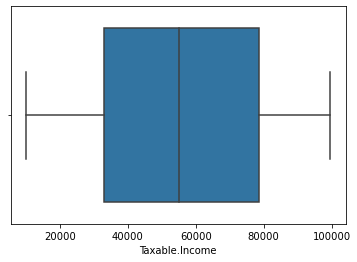

In [8]:
ax = sn.boxplot(fc1['Taxable.Income'])

# There are no outliers in the data set

In [9]:
plot.rcParams["figure.figsize"] = 9,5

Skew: 0.030014788906377175
Kurtosis: -1.1997824607083138


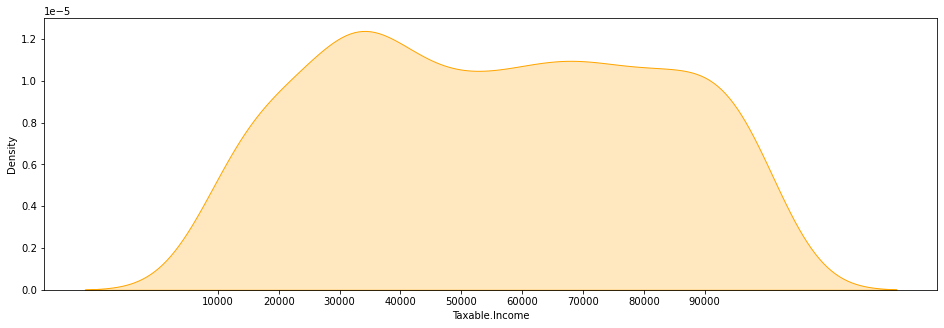

In [10]:
plot.figure(figsize = (16,5))
print("Skew: {}".format(fc1['Taxable.Income'].skew()))
print("Kurtosis: {}".format(fc1['Taxable.Income'].kurtosis()))
ax = sn.kdeplot(fc1['Taxable.Income'],shade = True,color = 'orange')
plot.xticks([i for i in range(10000,100000,10000)])
plot.show()

## The data is Skewed on the right side
## The data has negative Kurtosis.

In [11]:
obj_colum = fc1.select_dtypes(include = 'object').columns.tolist()

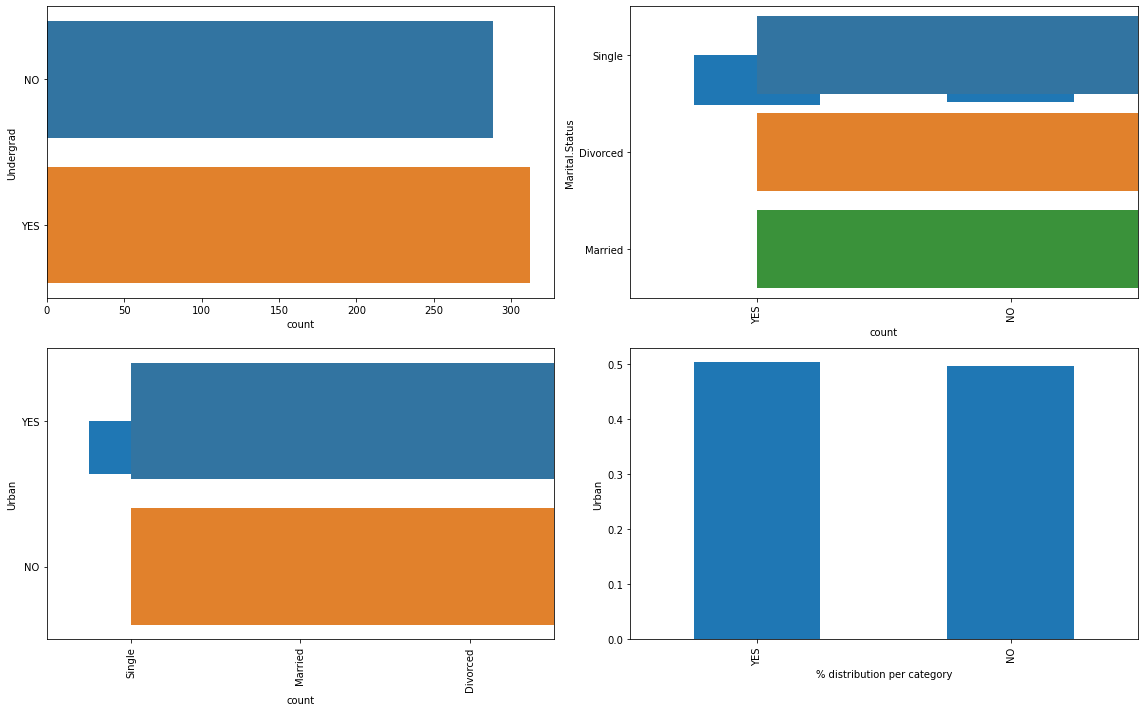

In [12]:
plot.figure(figsize = (16,10))
for i,col in enumerate(obj_colum,1):
    plot.subplot(2,2,i)
    sn.countplot(data = fc1,y = col)
    plot.subplot(2,2,i+1)
    fc1[col].value_counts(normalize = True).plot.bar()
    plot.ylabel(col)
    plot.xlabel('% distribution per category')
plot.tight_layout()
plot.show()  

In [13]:
num_columns = fc1.select_dtypes(exclude = 'object').columns.tolist()

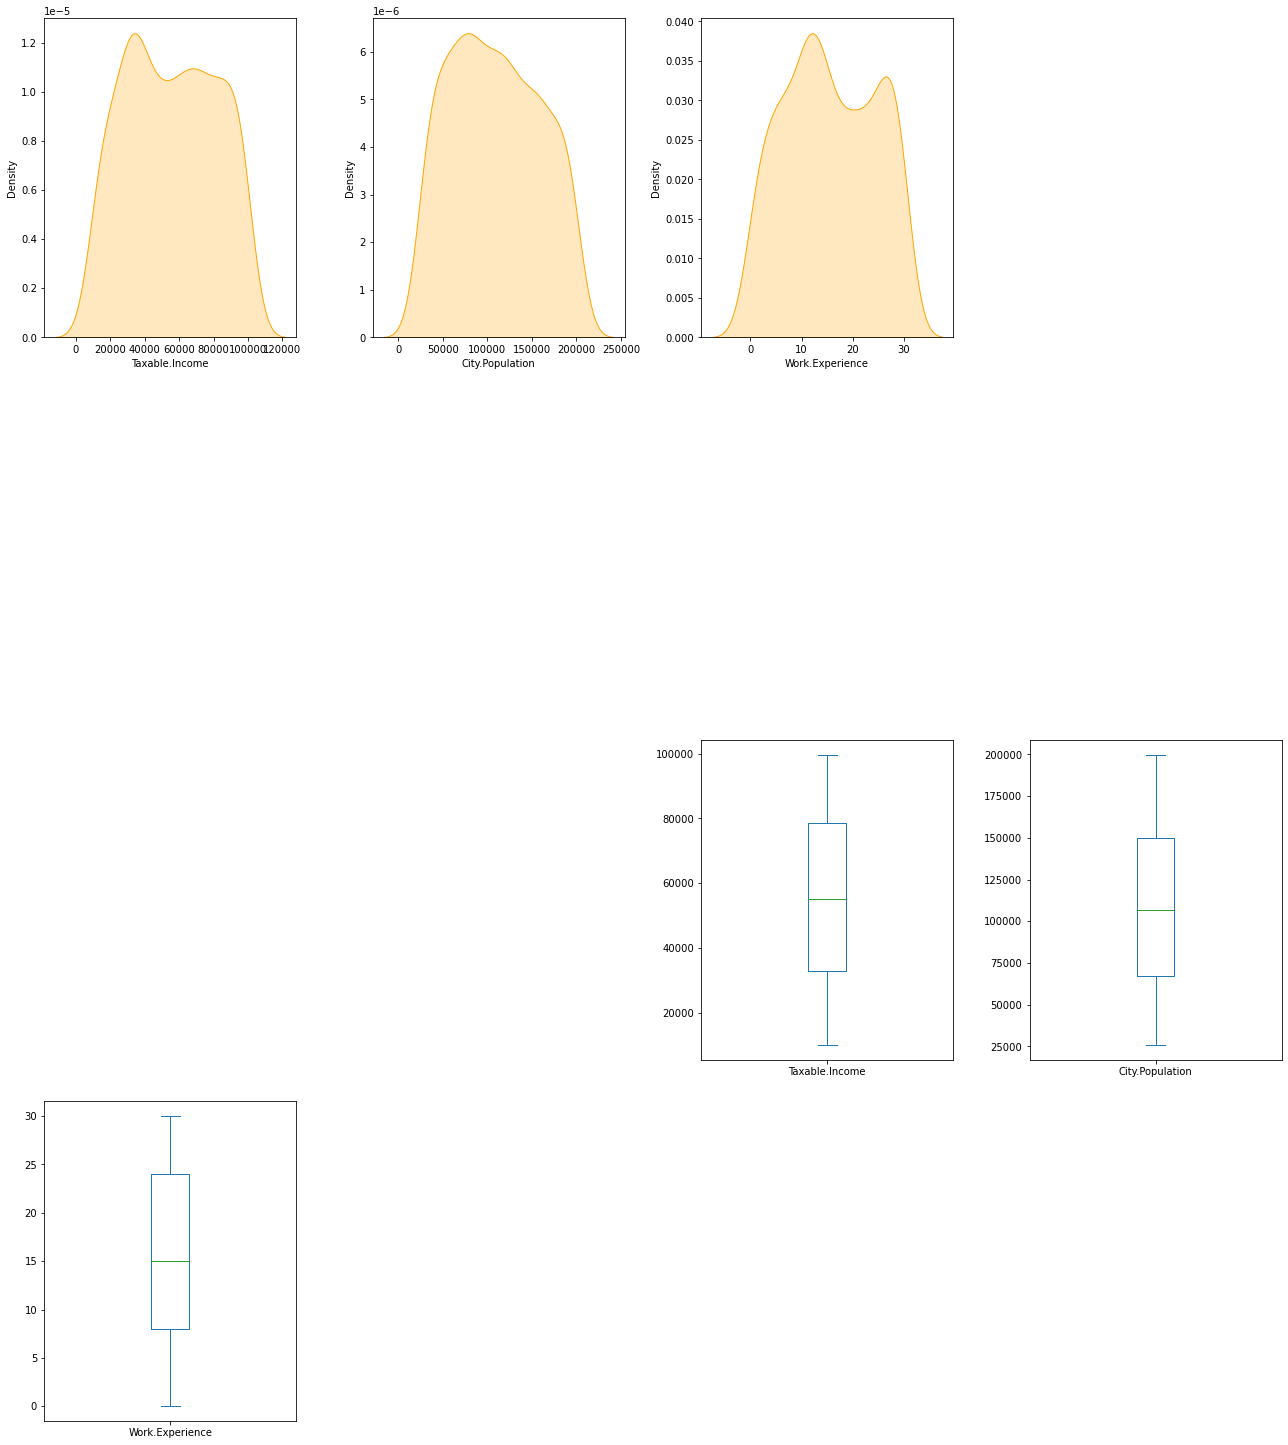

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


In [14]:
plot.figure(figsize = (18,40))
for i,col in enumerate(num_columns,1):
    plot.subplot(8,4,i)
    sn.kdeplot(fc[col],color = 'orange',shade = True)
    plot.subplot(8,4,i+10)
    fc[col].plot.box()
plot.tight_layout() 
plot.show()
num_data = fc[num_columns]
pd.DataFrame(data = [num_data.skew(),num_data.kurtosis()],index = ['skewness','kurtosis'])

In [15]:
fc1 = pd.get_dummies(fc1, columns = ['Undergrad','Marital.Status','Urban'])

In [16]:
corr = fc1.corr()

<AxesSubplot:>

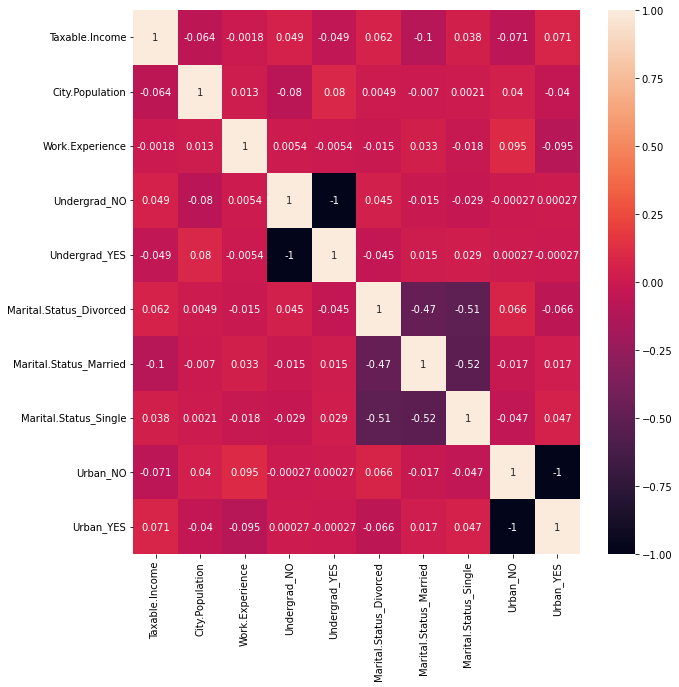

In [17]:
plot.figure(figsize = (10,10))
sn.heatmap(corr,annot = True)

# Random Forest

# Since the target variable is continious variable, we create a class of taxable_income <= 30000 as "Risky" and others as "Good".

In [18]:
fc1['Taxable.Income'] = pd.cut(fc1['Taxable.Income'],bins = [0,30000,100000],labels = ['risky','good'])

In [19]:
list(fc1.columns)

['Taxable.Income',
 'City.Population',
 'Work.Experience',
 'Undergrad_NO',
 'Undergrad_YES',
 'Marital.Status_Divorced',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_NO',
 'Urban_YES']

In [20]:
X = fc1.iloc[:,1:10]
y = fc1.iloc[:,0]

In [21]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [22]:
y_train.value_counts()

good     376
risky    104
Name: Taxable.Income, dtype: int64

In [23]:
model =RF(n_jobs = 4,n_estimators = 150, oob_score =True,criterion = 'entropy') 
model.fit(x_train,y_train)
model.oob_score_

0.7145833333333333

In [24]:
pred_train = model.predict(x_train)

In [25]:
accuracy_score(y_train,pred_train)

1.0

In [26]:
confusion_matrix(y_train,pred_train)

array([[376,   0],
       [  0, 104]], dtype=int64)

In [27]:
pred_test = model.predict(x_test)

In [28]:
accuracy_score(y_test,pred_test)

0.7416666666666667

In [29]:
confusion_matrix(y_test,pred_test)

array([[89, 11],
       [20,  0]], dtype=int64)

In [30]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})

In [31]:
df_t

,Actual,Predicted
443,risky,good
162,good,risky
71,good,good
215,good,good
492,good,risky
...,...,...
159,good,good
78,good,good
20,good,good
456,good,good


In [32]:
cols = list(fc1.columns)

In [33]:
predictors = cols[1:10]
target = cols[0]

In [34]:
tree1 = model.estimators_[20]

In [35]:
dot_data = StringIO()

In [36]:
export_graphviz(tree1, out_file = dot_data, feature_names = predictors, class_names = target, filled = True,rounded = True,impurity = False,proportion = False,precision = 2)

In [37]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Inference

## Since the accuracy of the Training dataset is 100% we test the accuracy on the test data which is 72%.
## As seen in the confusion matrix of Test data 94 instances are correct and 26 instances are not.

In [38]:
rf_small = RF(n_estimators = 10, max_depth = 3)

In [39]:
rf_small.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [40]:
tree_small = rf_small.estimators_[5]

In [41]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)

In [42]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [43]:
img = mpimg.imread(r'C:\\Users\\Dell\\Downloads\\fraud_small.png') 

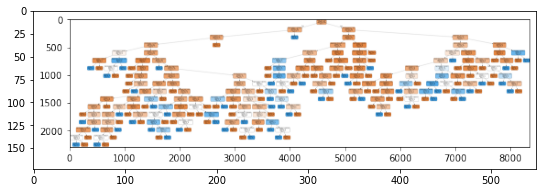

In [44]:
plot.imshow(img)

In [45]:
model.feature_importances_

array([0.50871821, 0.36567919, 0.01539475, 0.01690977, 0.01746508,
       0.02039197, 0.01865597, 0.01792634, 0.01885872])

In [46]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [47]:
fi

,feature,importance
0,City.Population,0.508718
1,Work.Experience,0.365679
5,Marital.Status_Married,0.020392
8,Urban_YES,0.018859
6,Marital.Status_Single,0.018656
7,Urban_NO,0.017926
4,Marital.Status_Divorced,0.017465
3,Undergrad_YES,0.016910
2,Undergrad_NO,0.015395


# As seen in the above table city population is the most important feature.